## Canadian Council of Ministers of the Environment 2001 Water Quality Index

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sns.set()
sns.set_palette('bright')
df = pd.read_csv('refined-data/eval_data.csv')
awqi = pd.read_csv('quality_estimate_and_wqi.csv')[['WQI','WQI_CLASSIF']]
ewqi = pd.read_csv('quality_estimate_and_entropy_wqi.csv')[['EWQI','EWQI_CLASSIF']]
df = pd.concat([df, awqi, ewqi], axis=1)
df

,DISTRICT,LOCATION,PH,EC,TDS,TH,CA,MG,NA,K,...,NO3,SO4,F,ALK,YEAR,SAR,WQI,WQI_CLASSIF,EWQI,EWQI_CLASSIF
0,Ahmedabad,Barvala,8.25,5090.0,3410.0,450.0,80.0,60.0,937.0,0.3,...,24.00,346.0,2.80,730.0,2017,NaN,179.179174,Unsuitable,307.655924,Unsuitable
1,Ahmedabad,Dhandhuka1,8.23,14210.0,9521.0,1300.0,180.0,207.0,3220.0,9.9,...,1600.00,1290.0,6.64,830.0,2017,NaN,503.168402,Unsuitable,1274.533598,Unsuitable
2,Ahmedabad,Endla,8.17,685.0,459.0,220.0,52.0,22.0,49.0,13.6,...,2.00,2.0,0.44,250.0,2017,NaN,39.979871,Good,59.095708,Poor
3,Ahmedabad,Kumarkhan,8.19,10660.0,7142.0,800.0,140.0,109.0,1875.0,7.2,...,32.00,443.0,11.20,810.0,2017,NaN,623.628660,Unsuitable,636.424848,Unsuitable
4,Ahmedabad,Kundali,8.03,1300.0,871.0,280.0,64.0,29.0,210.0,3.7,...,230.00,171.0,0.50,250.0,2017,NaN,57.007405,Poor,151.448314,Unsuitable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,Kutchch,Desalpur,7.42,768.0,515.0,180.0,40.0,19.0,95.0,10.0,...,3.20,70.0,0.15,150.0,2021,3.08,17.533385,Excellent,55.241104,Poor
2760,Kutchch,Ratanpar Khadir,7.73,4419.0,2961.0,701.0,96.0,112.0,712.0,17.0,...,13.00,310.0,0.78,330.0,2021,11.70,74.851919,Poor,287.785086,Unsuitable
2761,Kutchch,Rapar,7.60,2942.0,1971.0,400.0,132.0,17.0,552.0,26.0,...,33.00,538.0,0.93,230.0,2021,12.00,67.464524,Poor,196.862044,Unsuitable
2762,Kutchch,Kuda,7.35,1464.0,981.0,410.0,104.0,36.0,125.0,18.0,...,0.31,25.0,1.04,500.0,2021,2.68,69.255678,Poor,102.900091,Unsuitable


In [19]:
drinking_water_range = {
    # "Component": [Acceptable Limit, Permissible Limit in absence of alternative source]
    "PH": [6.5, 8.5], #
    "EC": [0, 1500], #
    "TDS": [500, 2000], #
    "ALK": [200, 600], #
    "TH": [200, 600], #
    "CL": [250, 1000], #
    "CA": [75, 200], #
    "MG": [30, 100], #
    "SO4": [200, 400], #
    "NO3": [0, 45], # 45 = acceptable and max limit
    "F": [1, 1.5], #
}

# "NA": [0, 200],
# "K": [0, 50],

In [20]:
import numpy as np

def calculate_F1(df, features, guideline_values):
    """
    Calculate F1: Number of parameters that do not meet water quality guidelines.
    
    Parameters:
    - df: DataFrame containing values of water quality parameters
    - features: List of water quality parameters
    - guideline_values: Dictionary containing guideline values for each parameter
    
    Returns:
    - F1: Number of parameters that exceed guidelines
    """
    F1 = sum(1 for feature in features if df[feature] < guideline_values[feature][0] or df[feature] > guideline_values[feature][1])
    return F1*100


def calculate_F2(df, features, guideline_values):
    """
    Calculate F2: Number of times guidelines are not followed.
    
    Parameters:
    - df: DataFrame containing values of water quality parameters
    - features: List of water quality parameters
    - guideline_values: Dictionary containing guideline values for each parameter
    
    Returns:
    - F2: Number of times guidelines are exceeded
    """
    F2 = sum(1 for feature in features if df[feature] > guideline_values[feature][1])
    return F2*100


def calculate_F3(df, features, guideline_values):
    """
    Calculate F3: Difference between measurements and guidelines.
    
    Parameters:
    - df: DataFrame containing values of water quality parameters
    - features: List of water quality parameters
    - guideline_values: Dictionary containing guideline values for each parameter
    
    Returns:
    - F3: Sum of absolute differences between measurements and guidelines
    """
    ls = []
    for feature in features:
        F3 = 0
        if df[feature] < guideline_values[feature][0]:
            F3 = (guideline_values[feature][0] - df[feature])/guideline_values[feature][0]
        elif df[feature] > guideline_values[feature][1]:
            F3 = (df[feature] - guideline_values[feature][1])/guideline_values[feature][1]
        ls.append(F3)
    nse = sum(ls)/len(features)
    return nse/(0.01*nse + 0.01)


def calculate_WQI(df, features, guideline_values):
    """
    Calculate Water Quality Index (WQI) for each instance in DataFrame.
    
    Parameters:
    - df: DataFrame containing values of water quality parameters
    - features: List of water quality parameters
    - guideline_values: Dictionary containing guideline values for each parameter
    
    Returns:
    - wqi: List of Water Quality Index (WQI) values for each instance
    """
    wqi_values = []
    for idx, row in df.iterrows():
        F1 = calculate_F1(row, features, guideline_values)
        F2 = calculate_F2(row, features, guideline_values)
        F3 = calculate_F3(row, features, guideline_values)
        wqi = (np.sqrt(F1*F1 + F2*F2 + F3*F3) / 1.732)  # Dividing by 1.732 to reduce the value to 100
        wqi_values.append(wqi)
    return wqi_values


# Example usage:
# Assuming df is your DataFrame containing water quality parameters
# And guideline_values is a dictionary containing guideline values for each parameter

# Calculating WQI for each instance
wqi_values = calculate_WQI(df, drinking_water_range.keys(), drinking_water_range)
# Adding WQI values to DataFrame
df['CCME-WQI'] = wqi_values
df['CCME-WQI'] = df['CCME-WQI'].apply(lambda x: np.abs(100-x))
# df['CCME-WQI'] = df['CCME-WQI'].apply(lambda x: x/100)
df['CCME-WQI']

0       226.995159
1       636.464313
2       246.641801
3       554.178212
4       251.737958
           ...    
2759    304.369604
2760    351.107792
2761    158.335265
2762     15.636121
2763    131.040537
Name: CCME-WQI, Length: 2764, dtype: float64

In [21]:
df

,DISTRICT,LOCATION,PH,EC,TDS,TH,CA,MG,NA,K,...,SO4,F,ALK,YEAR,SAR,WQI,WQI_CLASSIF,EWQI,EWQI_CLASSIF,CCME-WQI
0,Ahmedabad,Barvala,8.25,5090.0,3410.0,450.0,80.0,60.0,937.0,0.3,...,346.0,2.80,730.0,2017,NaN,179.179174,Unsuitable,307.655924,Unsuitable,226.995159
1,Ahmedabad,Dhandhuka1,8.23,14210.0,9521.0,1300.0,180.0,207.0,3220.0,9.9,...,1290.0,6.64,830.0,2017,NaN,503.168402,Unsuitable,1274.533598,Unsuitable,636.464313
2,Ahmedabad,Endla,8.17,685.0,459.0,220.0,52.0,22.0,49.0,13.6,...,2.0,0.44,250.0,2017,NaN,39.979871,Good,59.095708,Poor,246.641801
3,Ahmedabad,Kumarkhan,8.19,10660.0,7142.0,800.0,140.0,109.0,1875.0,7.2,...,443.0,11.20,810.0,2017,NaN,623.628660,Unsuitable,636.424848,Unsuitable,554.178212
4,Ahmedabad,Kundali,8.03,1300.0,871.0,280.0,64.0,29.0,210.0,3.7,...,171.0,0.50,250.0,2017,NaN,57.007405,Poor,151.448314,Unsuitable,251.737958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,Kutchch,Desalpur,7.42,768.0,515.0,180.0,40.0,19.0,95.0,10.0,...,70.0,0.15,150.0,2021,3.08,17.533385,Excellent,55.241104,Poor,304.369604
2760,Kutchch,Ratanpar Khadir,7.73,4419.0,2961.0,701.0,96.0,112.0,712.0,17.0,...,310.0,0.78,330.0,2021,11.70,74.851919,Poor,287.785086,Unsuitable,351.107792
2761,Kutchch,Rapar,7.60,2942.0,1971.0,400.0,132.0,17.0,552.0,26.0,...,538.0,0.93,230.0,2021,12.00,67.464524,Poor,196.862044,Unsuitable,158.335265
2762,Kutchch,Kuda,7.35,1464.0,981.0,410.0,104.0,36.0,125.0,18.0,...,25.0,1.04,500.0,2021,2.68,69.255678,Poor,102.900091,Unsuitable,15.636121


In [22]:
df['CCME-WQI_CLASSIF'] = pd.cut(df['CCME-WQI'], bins=[0, 45, 65, 80, 95, 100], labels=['Poor', 'Marginal', 'Fair', 'Good', 'Excellent'])
df['CCME-WQI_CLASSIF'].value_counts()

CCME-WQI_CLASSIF
Fair         138
Good          69
Poor          19
Excellent      7
Marginal       1
Name: count, dtype: int64

In [23]:
df.to_csv('combined-method-wqi-data.csv', index=False)

(0.0, 1000.0)

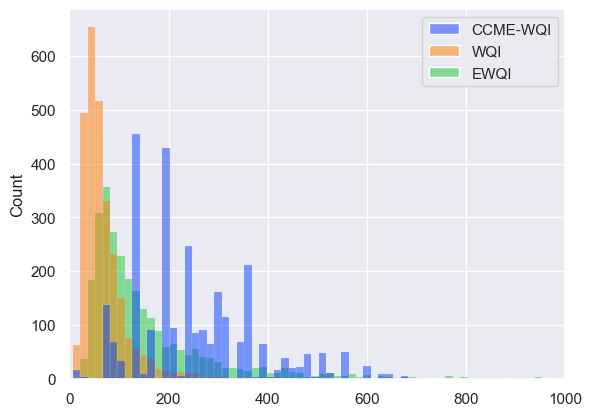

In [24]:
sns.histplot(data=df[['CCME-WQI','WQI','EWQI']])
plt.xlim(0, 1000)